# Creacion del modelo con LSTM

Despues de analizar diversos metodos para realizar predicciones sobre este activo tan particular, se decidio utilizar redes neuronales recurrentes.

Long Short-Term Memory son un tipo especial de redes neuronales recurrentes (RNN) diseñadas para modelar secuencias de datos donde el orden de los elementos es crucial.

In [285]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
import datetime
from lightgbm import LGBMRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import r2_score


In [286]:
conn = sql.connect('Data/db/btc.db')
cursor = conn.cursor()
df_1d = pd.read_sql_query("SELECT * FROM btc_1d", conn)

In [287]:
df_1d.tail(2)

,date,time,close,open,high,low,volume,var,return,diff,...,D,close_shifted,TR,ATR,TP,CCI,lag1_TR,lag2_TR,lag1_ATR,lag2_ATR
4973,2024-08-23 23:59:09,1724457600000,64157.01,64037.24,64494.50,63531.00,15857.15616,NaN,0.187032,119.77,...,85.008494,64037.24,963.50,2532.836429,64060.836667,136.666548,2312.21,1434.22,2437.815000,2572.219286
4974,2024-08-25 00:00:57,1724544000000,64169.99,64157.02,64507.04,63773.27,8909.11990,NaN,0.020216,12.97,...,90.609019,64157.01,733.77,2330.157857,64150.100000,132.352502,2600.00,2437.56,2496.201429,2553.417143


In [288]:
fecha = df_1d['date'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_1d)

# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)

df_1d['date'] = fechas

In [289]:
df_1d.index = fechas

In [290]:
print(len(df_1d.index))
print(len(pd.date_range(
                    start = df_1d.index.min(),
                    end   = df_1d.index.max())))
                    #freq  = data_1d.index.freq)))
print(df_1d.index.min())
print(df_1d.index.max())

4975
4975
2011-01-12 00:00:57
2024-08-25 00:00:57


Corroborar que el indice sea unico y no tenga nulos.

In [291]:
print(df_1d.index.is_unique)
print(df_1d.index.hasnans)

True
False


Comprobaciones de consistencia de datos diarios: el código verifica si el índice del DataFrame df_1d contiene una secuencia diaria continua, garantizando que no haya fechas faltantes o espacios en los datos.

In [292]:
(df_1d.index == pd.date_range(
                    start = df_1d.index.min(),
                    end   = df_1d.index.max())).all()

True

# Pronosticador Autoregresivo o ForecasterAutoreg

In [293]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=2,learning_rate=0.2,n_estimators=100,random_state=123),
    lags = [5,10,25,50,100,150,300]
)


In [294]:
forecaster.summary

<bound method ForecasterBase.summary of ================= 
ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.2, max_depth=2, random_state=123) 
Lags: [  5  10  25  50 100 150 300] 
Transformer for y: None 
Transformer for exog: None 
Window size: 300 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-08-29 19:17:48 
Last fit dat

In [295]:
df_1d.loc['2012-01-18 00:00:00':'2024-07-20 00:00:00'].shape

(4567, 34)

### Fechas de entrenamiento y validacion

In [296]:
data_1d = df_1d.loc['2012-01-18 00:00:00':'2024-07-20 00:00:00']
fin_train = '2023-07-15 00:00:00'
fin_validacion = '2024-07-15 00:00:00'

In [297]:
datos_train = data_1d.loc[:fin_train,:] # 2 años y 3 meses
datos_val = data_1d.loc[fin_train:fin_validacion,:] # 2 meses (Diferencia entre el final de los datos de train y la validacion)
datos_test = data_1d.loc[fin_validacion:,:] # 1 meses (fin de validacion a final de los datos)

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2012-01-18 00:00:57 --- 2023-07-14 00:00:57  (n=4196)
Fechas validacion : 2023-07-15 00:00:57 --- 2024-07-14 00:00:57  (n=366)
Fechas test : 2024-07-15 00:00:57 --- 2024-07-19 00:00:57  (n=5)


C:\Users\Pablo\AppData\Local\Temp\ipykernel_18236\1086612171.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



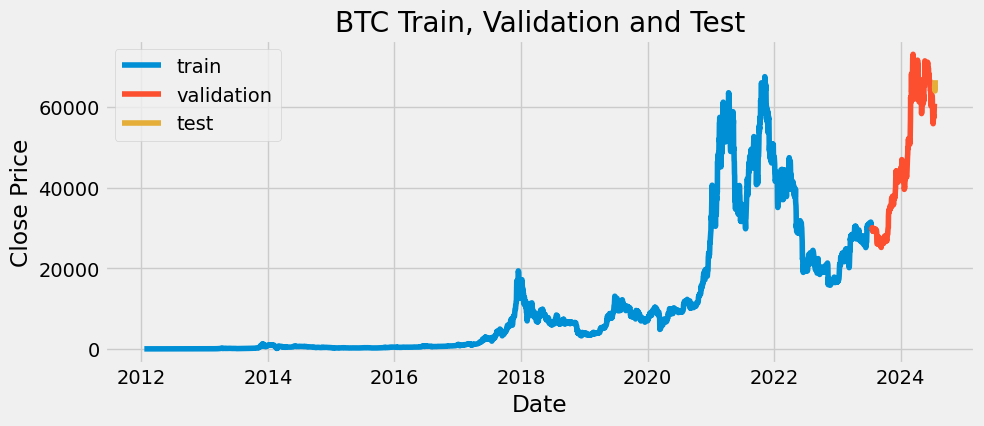

In [298]:
data_1d.loc[:fin_train,'partition'] = 'train'
data_1d.loc[fin_train:fin_validacion,'partition'] = 'validation'
data_1d.loc[fin_validacion:,'partition'] = 'test'

# Crear el gráfico
plt.figure(figsize=(10, 4))
for partition in ['train', 'validation', 'test']:
    subset = data_1d[data_1d['partition'] == partition]
    plt.plot(subset['date'], subset['close'], label=partition)

plt.title('BTC Train, Validation and Test')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [299]:
forecaster.fit(y=data_1d.loc[:fin_validacion,'close'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4262, number of used features: 7
[LightGBM] [Info] Start training from score 14390.713435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [300]:
predicciones = forecaster.predict(steps=5)
predicciones

2024-07-15 00:00:57    56195.194140
2024-07-16 00:00:57    55814.297748
2024-07-17 00:00:57    58024.776735
2024-07-18 00:00:57    57311.711398
2024-07-19 00:00:57    60660.011823
Freq: D, Name: pred, dtype: float64

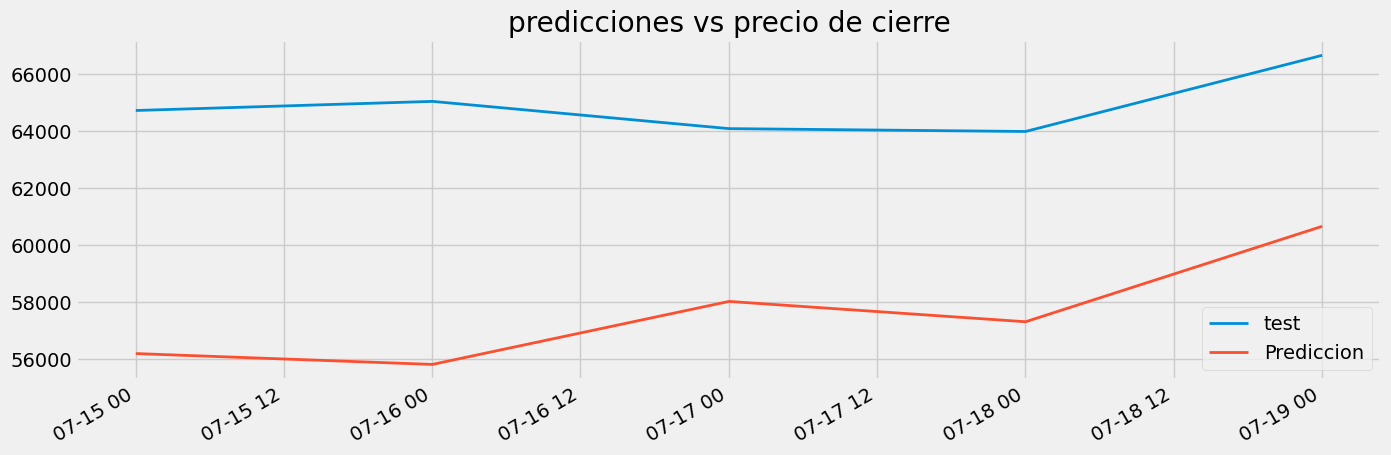

In [301]:
fig, ax = plt.subplots(figsize=(15,5))
data_1d.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()

In [302]:
# Error test
# ==============================================================================
r2 = r2_score(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {r2}")

Error de test (mse): -58.317726530413566


# Optimizacion de hiperparametros


In [303]:
## Búsqueda de hiperparámetros: grid search
## ==============================================================================
#steps = 19
#forecaster = ForecasterAutoreg(
#                regressor = LGBMRegressor(random_state=123),
#                lags      = 12 # Este valor será remplazado en el grid search
#             )
#
## Valores candidatos de lags
#lags_grid = [[10,25,50,75,100],
#             [50,100,150,200],
#             [30,180,360],
#             [5,25,50]]
#
## Valores candidatos de hiperparámetros del regresor
#param_grid = {
#      'n_estimators': [100, 250,500],
#      'max_depth': [3, 5, 10],
#      'learning_rate': [0.1,0.01]
#}
#
#resultados_grid = grid_search_forecaster(
#                        forecaster         = forecaster,
#                        y                  = datos_train['close'],
#                        param_grid         = param_grid,
#                        lags_grid          = lags_grid,
#                        steps              = steps,
#                        refit              = False,
#                        metric             = 'mean_squared_error',
#                        initial_train_size = int(len(datos_train)*0.5),
#                        fixed_train_size   = False,
#                        return_best        = True,
#                        n_jobs             = 'auto',
#                        verbose            = False
#                  )

In [304]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=5,learning_rate=0.1,n_estimators=500,random_state=123),
    lags = [50,100,150,200]
)

In [305]:
forecaster.fit(y=datos_train['close'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 3996, number of used features: 4
[LightGBM] [Info] Start training from score 11052.479063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [309]:
steps=5
predicciones = forecaster.predict(steps=steps)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


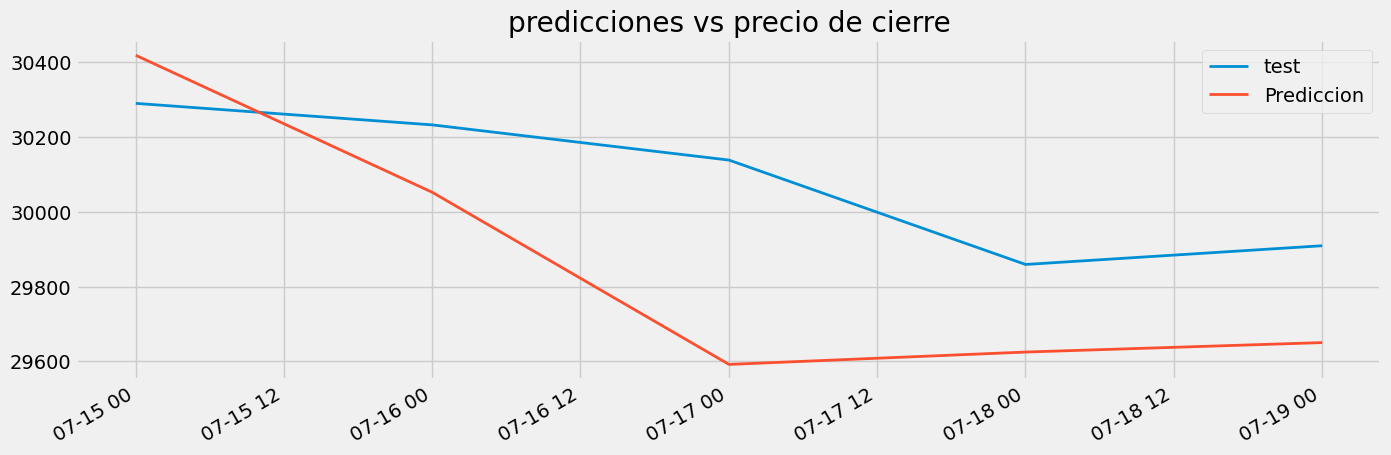

In [310]:
fig, ax = plt.subplots(figsize=(15,5))
data_1d.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()

In [311]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 1228369369.9177084


In [312]:
# Error test
# ==============================================================================
r2 = r2_score(
                y_true = datos_test['close'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {r2}")

Error de test (mse): -1322.5293395198717
